# IMPORT REQUIRED LIBRARY

In [1]:
import pandas as pd
import os
import codecs
import gensim.corpora as corpora
from snownlp import SnowNLP
from snownlp import normal
from snownlp import seg
from tqdm import tqdm
import re
import numpy as np
import json
import matplotlib.pyplot as plt

from sentiment_modeling import Sentiment_classfifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from keras.models import Model, Input
from sklearn.model_selection import train_test_split

# GET DATA

In [2]:
path = os.path.abspath(os.getcwd()) 
filename = path+"\\dataset\\organized_dataset\\csv-final.csv"

In [3]:
## Check data type
import chardet
with open(filename, 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [4]:
df = pd.read_csv(filename, encoding = 'UTF-16', sep='\t')

### Cut the information of original email

In [90]:
df['merged'] = df['Body']+df['Subject']
check = df['merged'].isnull()
contents = [df['merged'][i] for i in range(len(check)) if check[i] == False] #Filter the email which has non content

In [91]:
for i in range(len(contents)):
    for j in range(len(contents[i])):
        if contents[i][j:j+len('SecuShare')] == 'SecuShare': #Cut the information for original email
            contents[i] = contents[i][:j]

### Preprocess function

In [92]:
def filter_chinese(mycontents):
    #Filter to get a sentnece only chinese
    for n in range(len(mycontents)):
        temp_list = ""
        for i in re.findall("[\u4e00-\u9fff]",mycontents[n]):
            temp_list += i
        mycontents[n] = temp_list
    return mycontents

In [93]:
def handle(doc):
    han_text = normal.zh2hans(doc) #Conver Traditional chinese to simplfied chinese
    words = seg.seg(han_text) #segment the sentences
    words = normal.filter_stop(words)
    return words

def sent_to_words(sentences): #Preprocess data
    word_list = list()
    for i in tqdm(range(len(sentences))):
        word_list.append(handle(sentences[i]))
    return word_list

In [94]:
def preprocessing(data_words, max_length, token2id):
    preprocessed_text = np.ones((len(data_words), max_length))*len(token2id) #Assign id=length for the word not in the id2word dictiornary 
    for row_id in tqdm(range(len(data_words))):
        for col_id in range(max_length):
            if col_id < len(data_words[row_id]):
                if data_words[row_id][col_id] in token2id:
                    preprocessed_text[row_id][col_id] = token2id[data_words[row_id][col_id]] #Assign id for the word in id2word dictiornary

    return preprocessed_text

### Preprocess data

In [95]:
contents = filter_chinese(contents)

In [96]:
data_words = sent_to_words(contents)           

100%|██████████████████████████████████████████████████████████████████████████████| 2525/2525 [05:45<00:00,  7.31it/s]


In [97]:
id2word = corpora.Dictionary(data_words)
max_length = max([len(i) for i in data_words])
token2id = id2word.token2id

In [98]:
preprocessed_text = preprocessing(data_words, max_length, token2id)

100%|████████████████████████████████████████████████████████████████████████████| 2525/2525 [00:00<00:00, 3214.47it/s]


# LABEL DATA (CLUSTERING)

## Sentiment label

#### Creating new label (if sentiment_label file is not existed)

In [15]:
%%script This cell was disable --no-raise-error

bayes_modelpath = path+"\\sentiment_modeling\\saved_model\\sentiment_bayes\\sentiment_bayes.marshal"
sentiment_classifier = Sentiment_classfifier(bayes_modelpath)
sentiment_labels = sentiment_classifier.predict(contents)

100%|████████████████████████████████████████████████████████████████████████████| 2525/2525 [00:00<00:00, 5529.59it/s]


In [79]:
%%script This cell was disable --no-raise-error

#Save label
saved_dict = {'sentiment_id': sentiment_labels, 'sentiment_title': ['neg', 'pos']}
with codecs.open('sentiment_label.json', 'w', encoding='utf-8') as f:
    json.dump(saved_dict, f, ensure_ascii=False)

#### Reading available label

In [80]:
sentiment_labels = []
sentiment_titles = []
with codecs.open('sentiment_label.json', 'r', 'utf-8') as data_file:
    sentiment_parameters = json.load(data_file)
    sentiment_labels = sentiment_parameters['sentiment_id']
    sentiment_titles = sentiment_parameters['sentiment_title']

In [81]:
#Convert to one hot vector:
n_values = np.max(sentiment_labels) + 1
sentiment_labels = np.eye(n_values)[sentiment_labels]

## Topic label

#### Proprocess of topic analysising

In [20]:
%%script This cell was disable --no-raise-error

import stopwordsiso
from stopwordsiso import stopwords
import jieba
import jieba.analyse as analyse
import jieba.posseg as posseg
import opencc
from opencc import OpenCC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Convert list Simple Chinese stopword to Traditional stopword 
stop_words = list(stopwords(["zh"]))
stopa = []
for i in stop_words:
    cc = OpenCC('s2t')
    texta = cc.convert(i)
    stopa.append(texta)
    

def postag(text):
    pos = ['n', 'a', 'v', 'd'] #'nv', 'vd', 'vn', 'vx', 'vi'
    text_out = []
    for word, flag in posseg.cut(text):
        if flag in pos:
            text_out.append(word)
    return text_out

def preprocessingTextFull(text, sep = ' '):
# regex
    text = text.lower()
    text = re.sub(r'&lt;', '', text) #remove '&lt;' tag
    text = re.sub(r'<.*?>', '', text) #remove html
    text = re.sub(r'[^\w\s]', '', text) #remove punctiation
    text = re.sub('[^\u4e00-\u9fa5]+', '', text) # remove ASCII strings
    # remove stopword
    more_s = ['幫','忙', '請','謝', '謝', '您','好','姓','名', '_','喔','想','感','問','題','没','沒','為',
             "客","服","信","箱","電","子","目","前","公","司","服","務","郵","件","心", "擎","先",
              "生","軟","體","謝","教","育","教","育","雲","科","技","國","鼎","新","高","雄","市",
              "民","政","局","台","南","糖","網","擎","急","安","泰","兆","豐","可","口","可","樂","口","樂","濟","部","飯","店","潛","客","戶",
             "邱","良","姐","咖","啡", '附',
              '歡','迎','次','寶',"瘦", "仍","然",'彰','化', "工","業",'企','業', '聯','絡','工','提','供','孟', '秋', '東', '際', '睿', '明']

    stop = stopa  + more_s
    text = "".join([word for word in text if word not in stop]) #remove stopwords
    
    for c in ['\r', '\n', '\t'] :
        text = re.sub(c, ' ', text) #replace newline and tab with tabs\
        text = re.sub('\s+', ' ', text) #replace multiple spaces with one space
        
    text_cut = sep.join(jieba.cut(text, cut_all=False))
    
    return text_cut

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

#### Creating new label (if sentiment_label file is not existed)

In [14]:
%%script This cell was disable --no-raise-error

#Drop useless attributes
df1 = df.drop(columns = ['From','From Email', 'To', 'Cc','Bcc'], axis = 0)
df1 = df1.dropna()

#Create new feature: merge
df1['merged'] = df1['Body']+df1['Subject']
df1['merged'] = df1['merged'].apply(preprocessingTextFull) # mergerd and preprocessing

#Create new feature: clean_text
pos_text = df1['merged'].apply(postag)
df1['clean_text'] = pos_text
df1['clean_text'] = df1['clean_text'].apply(lambda x: ' '.join(map(str, x)))
df1['clean_text'] = df1['clean_text'].apply(preprocessingTextFull)

clean_text=df1['clean_text'].tolist() # propcessed with pos
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=50000)
data_vectorized = vectorizer.fit_transform(clean_text) # fit input data

In [50]:
%%script This cell was disable --no-raise-error

# Information of model
# lda_model = LatentDirichletAllocation(n_components=4,
#                                       max_iter=10, 
#                                       learning_method='online',
#                                       learning_offset=70.,
#                                       learning_decay = .7,
#                                       random_state=0).fit(data_vectorized)

# with open(path+"\\topic_modeling\\Final_version\\sklearn_lda_model.pk","wb") as f:
#     pickle.dump(lda_model, f)

lda_model = pickle.load(open(path+"\\topic_modeling\\Final_version\\sklearn_lda_model.pk", 'rb'))
doc_topic_matrix = lda_model.transform(data_vectorized)
dominant_topic = np.argmax(doc_topic_matrix, axis=1)
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)  
my_topic_key = ['_'.join(topic.tolist()) for topic in topic_keywords]

In [69]:
%%script This cell was disable --no-raise-error

#Save label
saved_dict = {'topic_id': dominant_topic.tolist(), 'topic_title': my_topic_key}
with codecs.open('topic_label.json', 'w', encoding='utf-8') as f:
    json.dump(saved_dict, f, ensure_ascii=False)

#### Reading available label

In [84]:
topic_labels = []
topic_title = []
with codecs.open('topic_label.json', 'r', 'utf-8') as data_file:
    topic_parameters = json.load(data_file)
    topic_labels = topic_parameters['topic_id']
    topic_title = topic_parameters['topic_title']

In [85]:
#Convert to one hot vector:
n_values = np.max(topic_labels) + 1
topic_labels = np.eye(n_values)[topic_labels]

# BUILDING MODEL FOR PREDICTION (PREDICTION)

In [88]:
class BiLstm:
    def __init__(self,vocabulary_size, seq_len):
        
        input_shape = Input((seq_len,))
        embedding_layer = Embedding(vocabulary_size, 128, input_length=seq_len)(input_shape)
        
        bilstm_layer1 = Bidirectional(LSTM(64))(embedding_layer)
        dropout_layer1 = Dropout(0.5)(bilstm_layer1)
        dense_layer1 = Dense(64, activation='relu')(dropout_layer1)
        
        bilstm_layer2 = Bidirectional(LSTM(64))(embedding_layer)
        dropout_layer2 = Dropout(0.5)(bilstm_layer2)
        dense_layer2 = Dense(64, activation='relu')(dropout_layer2)
        
        out1 = Dense(2, activation='softmax')(dense_layer1)    
        out2 = Dense(4, activation='softmax')(dense_layer2)
        
        self.model = Model(input_shape, [out1,out2])
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history

    def fit(self, x, y1, y2,mybatch_size = 256,myepochs = 5):
        self.history = self.model.fit(x, [y1,y2], batch_size=mybatch_size, epochs=myepochs)
        
    def prediction(self,x):
        return self.model.predict(x)#.reshape(-1,1) ##size col = 41, row = 1 ==> y = (1,25949) //but only y[8],y[11] or y[12] keep the result
           
    def test(self,x,y):
        y_pred = self.model.predict(x)
        y_test = np.array(y)

        print("Accuracy of testing: ",mylossfunction(y_pred,y_test))
        #print("ROC Area: ")
        #roc_error =  myROCfunction(y_test,y_pred)
        #for i in range(len(roc_error)):
        #  print("- Class ",i," = %0.2f",roc_error[i])

    def save_model(self,name):
        self.model.save(name + "-BiLSTM")
    
    def load_model(self,name):
        self.model = keras.models.load_model(name + "-BiLSTM")
            
    def history(self):
        return self.history

# TRAINING

### Define Training Dataset

In [99]:
X = preprocessed_text
y1 = sentiment_labels
y2 = topic_labels
#y = np.hstack((topic_labels,sentiment_labels))
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [100]:
vocabulary_size = len(id2word) + 1
seq_len = np.shape(X)[1] #Sequence length = sentence length
input_dim = vocabulary_size 
input_length = seq_len
mybatch_size = 256
myepochs = 5

### Training Model

In [101]:
myBiLSTM = BiLstm(input_dim, input_length)
myBiLSTM.fit(X,y1,y2,mybatch_size,myepochs)

Epoch 1/5
10/10 [==============================] - 6379s 658s/step - loss: 1.8576 - dense_2_loss: 0.5729 - dense_3_loss: 1.2848 - dense_2_accuracy: 0.8143 - dense_3_accuracy: 0.5042
Epoch 2/5
10/10 [==============================] - 6366s 634s/step - loss: 1.4340 - dense_2_loss: 0.3516 - dense_3_loss: 1.0824 - dense_2_accuracy: 0.8451 - dense_3_accuracy: 0.5549
Epoch 3/5
10/10 [==============================] - 6704s 671s/step - loss: 1.1762 - dense_2_loss: 0.2115 - dense_3_loss: 0.9646 - dense_2_accuracy: 0.8911 - dense_3_accuracy: 0.5663
Epoch 4/5
10/10 [==============================] - 7580s 756s/step - loss: 0.8919 - dense_2_loss: 0.1733 - dense_3_loss: 0.7186 - dense_2_accuracy: 0.9208 - dense_3_accuracy: 0.7370
Epoch 5/5
10/10 [==============================] - 7576s 754s/step - loss: 0.7265 - dense_2_loss: 0.1382 - dense_3_loss: 0.5883 - dense_2_accuracy: 0.9434 - dense_3_accuracy: 0.7794


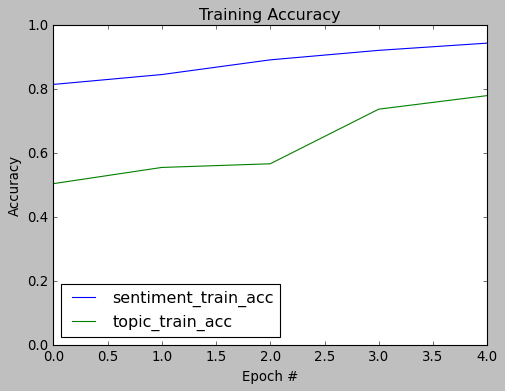

In [212]:
plt.style.use("classic")
plt.figure(figsize=[7,5])
N = myepochs
plt.plot(np.arange(0, N), myBiLSTM.history.history['dense_2_accuracy'], label="sentiment_train_acc")
plt.plot(np.arange(0, N), myBiLSTM.history.history['dense_3_accuracy'], label="topic_train_acc")
plt.title("Training Accuracy")
plt.ylim([0, 1])
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

### Save model and parameters

In [104]:
myBiLSTM.save_model("saved_model\\customer_preferences_model")  

INFO:tensorflow:Assets written to: saved_model\customer_preferences_model-BiLSTM\assets


INFO:tensorflow:Assets written to: saved_model\customer_preferences_model-BiLSTM\assets


In [105]:
#Save parameters
saved_dict = {'max_length': max_length, 'token2id': token2id}
with codecs.open('saved_model\\token2id.json', 'w', encoding='utf-8') as f:
    json.dump(saved_dict, f, ensure_ascii=False)

# PREDICTION

In [106]:
myBiLSTM.load_model("saved_model\\customer_preferences_model")

In [107]:
# Loading parameters
with codecs.open('saved_model\\token2id.json', 'r', 'utf-8') as data_file:
    parameters = json.load(data_file)

In [108]:
# Pre_processing by Preprocess function 
text = contents
text = filter_chinese(text)
pre_data_words = sent_to_words(text)  
data = preprocessing(pre_data_words, parameters['max_length'], parameters['token2id']) 

100%|████████████████████████████████████████████████████████████████████████████| 2525/2525 [00:00<00:00, 2538.02it/s]


In [109]:
# Prediction
result = myBiLSTM.prediction(data)

In [116]:
#print("Sentiment", result[0].tolist()) #List of probability of 'neg', 'pos'
#print("Topic", result[1].tolist()) #Lis of probability of 20 topics

In [115]:
i = 10
print("Predicting sentiment and topic of sentence {} in dataset: \n-Sentiment: {} \n-Topic: {}\n".format(i, result[0].tolist()[i], result[1].tolist()[i]))
print("Real value of sentiment and topic of sentence {} in dataset: \n-Sentiment: {} \n-Topic: {}".format(i, y1[i], y2[i]))

Predicting sentiment and topic of sentence 10 in dataset: 
-Sentiment: [0.8473025560379028, 0.15269744396209717] 
-Topic: [0.9527600407600403, 0.02527904324233532, 0.010670563206076622, 0.011290397495031357]

Real value of sentiment and topic of sentence 10 in dataset: 
-Sentiment: [1. 0.] 
-Topic: [1. 0. 0. 0.]


# DATA ANALYSIS AND CONCLUSION

## Description of dataset

Text(0.5, 1.0, 'Segregation of Topic Clusters')

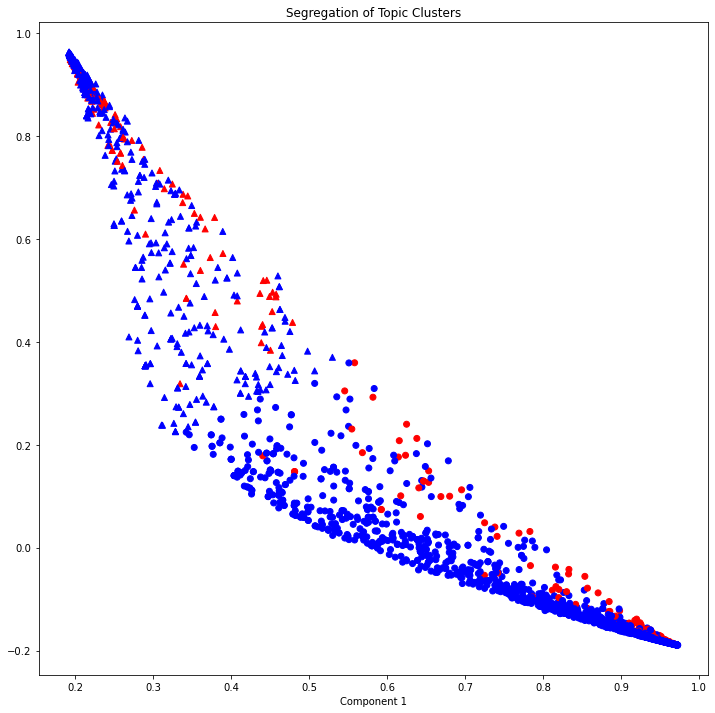

In [195]:
#Shape is topic, color is emotion (red = negative, blue = positive)